In [0]:
import random
import gym
import numpy as np
import torch as T
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from itertools import count

TOTAL_TIMESTEPS = 1e5 # 100k timesteps (frames of experience)
Q_FACTOR = 0.9        # Q-learning discount factor
BATCH_SIZE = 64       # Q-learning batch size
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')

# Neural Net Definition

In [0]:
class Policy(nn.Module):
    def __init__(self, in_shape, num_actions):
        super().__init__()
        # input is uni-dimensional for cartpole
        self.net = nn.Sequential(
            nn.Linear(in_shape, 20),
            nn.ReLU(True),
            nn.Linear(20, num_actions),
        )
    def forward(self, x):
        return self.net(x)

# Main

In [10]:
env = gym.make('CartPole-v1')
in_dim = env.observation_space.shape[0]
policy_dim = env.action_space.n

policy = Policy(in_dim, policy_dim).to(DEVICE)
optim = Adam(policy.parameters(), 5e-4)

total_steps = 0
scheduler = LambdaLR(optim, lambda i: 1 - total_steps / TOTAL_TIMESTEPS)
criterion = nn.MSELoss()
memory = []

all_log_rwd = []  # (num_steps, reward)
eval_log_rwd = [] # (num_steps, reward)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
def mk_torch(x):
    x = T.from_numpy(x).float()
    x = x.to(DEVICE)
    return x

def get_action(state, eps):
    # eps greedy sample action
    if np.random.random() > eps:
        x = mk_torch(state).unsqueeze(0)
        return int(policy(x).max(1)[1].cpu().item())
    return int(np.random.randint(2))

for ep in count():
    
    # eps greedy coefficient
    eps = max(0.0, (0.5 - (total_steps / TOTAL_TIMESTEPS)))
    ob = env.reset()
    done = False
    ep_steps = 0

    while not done:
        
        # eps greedy action step
        act = get_action(ob, eps)
        nob, rwd, done, info = env.step(act)
        total_steps += 1
        ep_steps += 1
        if done:
            rwd = 0
            all_log_rwd.append((total_steps, ep_steps))

        # update memory <S,A,R,S'>
        memory.append([ob, act, rwd, nob])
        ob=nob

        if len(memory) <= BATCH_SIZE:
            continue
        if len(memory) > 16000:
            del memory[0]

        # random sample minibatch
        mb = random.sample(memory, BATCH_SIZE)
        mb_S, mb_A, mb_R, mb_nS = map(mk_torch, map(np.stack, zip(*mb)))
        mb_R = (mb_R - mb_R.mean()) / (mb_R.std() + 1e-6)

        # Q learn
        Q = policy(mb_S).gather(1, mb_A.unsqueeze(1).long())
        max_nQ = policy(mb_nS).detach().max(1)[0]
        Q_target = mb_R + Q_FACTOR*max_nQ

        # policy step
        optim.zero_grad()
        loss = criterion(Q.squeeze(), Q_target)
        loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), 1)
        optim.step()

        #evaluate
        if ep % 10 == 0:
            r, done, ob = 0, False, env.reset()            
            while not done:
                act = get_action(ob, 0)
                ob, rwd, done, info = env.step(act)
                r += 1
            eval_log_rwd.append((total_steps, r))
            print(f'RWD: {r}\tL: {loss.item():2f}\t[{total_steps}]')
        
    if total_steps >= TOTAL_TIMESTEPS:
        break
    
    scheduler.step(total_steps)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


RWD: 116	L: 0.919250	[283]
RWD: 19	L: 0.039452	[662]
RWD: 10	L: 0.989217	[863]
RWD: 47	L: 0.968176	[1074]
RWD: 26	L: 0.962320	[1346]
RWD: 25	L: 0.727412	[1578]
RWD: 27	L: 0.889692	[1756]
RWD: 40	L: 0.939235	[2137]
RWD: 53	L: 1.025420	[2689]
RWD: 42	L: 0.631019	[3161]
RWD: 59	L: 0.957224	[3716]
RWD: 53	L: 1.064615	[4151]
RWD: 373	L: 0.966352	[4817]
RWD: 205	L: 0.911160	[5487]
RWD: 500	L: 0.982056	[6429]
RWD: 500	L: 0.074813	[7807]
RWD: 500	L: 0.890381	[9984]
RWD: 500	L: 0.628916	[12995]
RWD: 500	L: 0.052340	[16077]
RWD: 500	L: 0.044921	[18755]
RWD: 477	L: 0.021261	[22669]
RWD: 500	L: 0.011501	[26342]
RWD: 500	L: 0.019486	[30718]
RWD: 500	L: 0.003138	[34992]
RWD: 330	L: 1.022503	[39033]
RWD: 334	L: 0.004401	[42131]
RWD: 298	L: 0.003913	[45222]
RWD: 246	L: 0.003897	[47716]
RWD: 250	L: 0.003680	[50033]
RWD: 292	L: 0.001968	[52418]
RWD: 315	L: 0.980527	[54794]
RWD: 313	L: 0.004553	[57179]
RWD: 256	L: 0.001730	[59563]
RWD: 239	L: 0.002957	[61711]
RWD: 255	L: 0.003173	[63864]
RWD: 247	L: 0.00

# Plot results

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

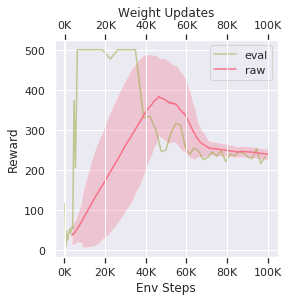

In [26]:
# plot with seaborn
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel('Env Steps')
ax.set_ylabel('Reward')
clrs = sns.color_palette("husl", 8)

# eval
df = pd.DataFrame(eval_log_rwd, columns =['Frames', 'Reward'])
p1, = ax.plot(df['Frames'], df['Reward'], c=clrs[2], alpha=0.5, label='eval')

# compute rolling avg and std
df = pd.DataFrame(all_log_rwd, columns =['Frames', 'Reward'])
sma_y = df['Reward'].rolling(100).mean()
std_y = df['Reward'].rolling(100).std()

# fill standard deviation
p2, = ax.plot(df['Frames'], sma_y, c=clrs[0], label='raw')
ax.fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0]) 

plt.legend([p1, p2], ['eval', 'raw'])

# make x axis nice
xlabels = [f'{int(x)}K' for x in ax.get_xticks()/1e3]
ax.set_xticklabels(xlabels)

ax2 = ax.twiny()
ax2.plot(df['Frames'], df['Reward'], c=clrs[2], alpha=0) # Create a dummy plot
ax2.set_xticklabels(xlabels)
ax2.set_xlabel('Weight Updates')

plt.savefig('cartpole_fig_dqn.png', dpi=300, pad_inches=0, bbox_inches = 'tight')
plt.show()

In [0]:
from google.colab import files
files.download('cartpole_fig_dqn.png')